In [38]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [39]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset


sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [40]:
print (fn_plot_torch_hist.__doc__)

None


In [41]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [42]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './torch_models'
subDir = 'fashion'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [43]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [44]:
trainfilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
testfilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
class_labels = {0: 'T-shirt/top',
            1: 'Trouser', 
            2: 'Pullover', 
            3:'Dress', 
            4:'Coat', 
            5:'Sandal', 
            6:'Shirt', 
            7:'Sneaker',
            8:'Bag', 
            9:'Ankle boot'}

In [71]:
class GlobalScalar:
    _instance =None

    def __init__(self) -> None:
        if GlobalScalar._instance is not None:
            raise Exception ('GlobalScalar class in Singleton')
        
        self.scaler = StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScalar()
        return cls._instance

In [72]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [73]:
class FashionDS(Dataset):
    globalScalar = GlobalScalar.get_instance()

    def __init__(self, 
                 dataframe: pd.DataFrame,
                 device: str = device):

        self.df = dataframe
        self.device = device
        
        self.labels = self.df['label'].to_numpy()
        X = self.df.drop('label', axis = 1).to_numpy()

        self.features = X/255

    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]

        # Convert to PyTorch tensors
        features = torch.tensor(features,
                                dtype=torch.float32,
                                device=self.device)
        
        label = torch.tensor(label,
                                dtype=torch.int64,
                                device=self.device)
        return features, label

In [74]:


train_ds = FashionDS(train_df)

test_ds = FashionDS(test_df)

In [75]:
train_loader = DataLoader(train_ds, 
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_loader = DataLoader(test_ds,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [76]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()

targets = targets.cpu().numpy()

targets

array([6, 2, 3, 7, 7, 9, 4, 8, 7, 7, 9, 6, 5, 6, 0, 3, 9, 1, 4, 7, 7, 4,
       2, 6, 0, 0, 9, 5, 7, 1, 1, 4], dtype=int64)

In [78]:
class_labels[targets[0]]

'Shirt'

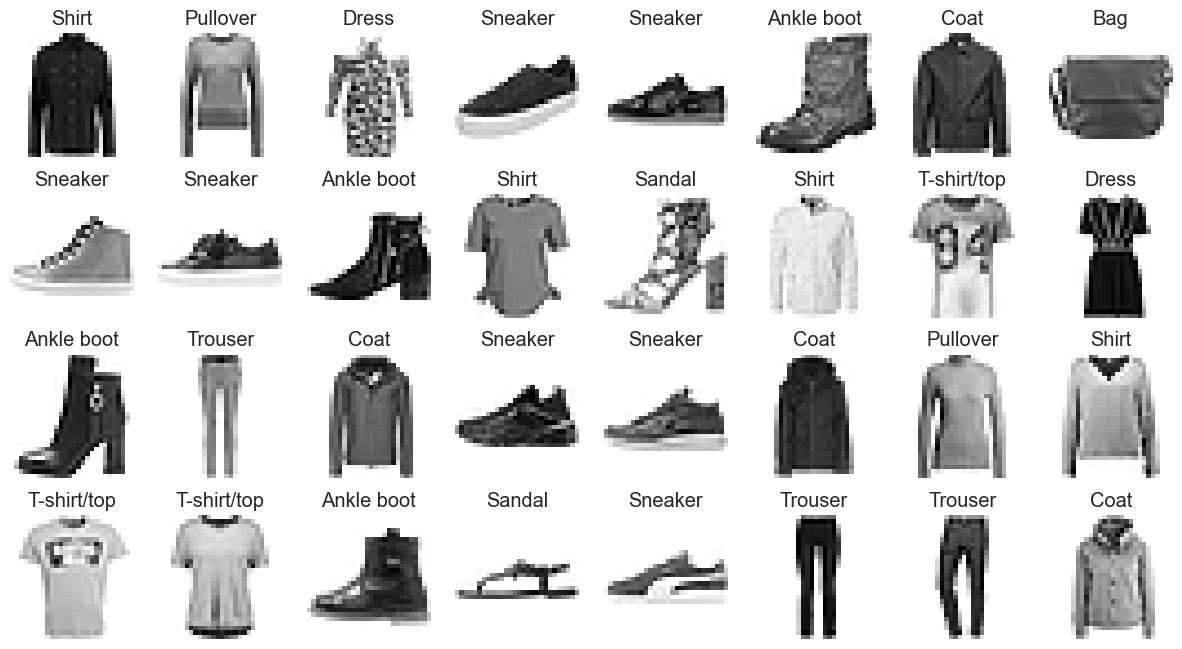

In [80]:
plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(images[i].reshape(28,28), cmap= plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_labels[targets[i]])
    

In [52]:
next(iter(train_ds))

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,
         0.2000, 0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [53]:
next(iter(test_ds))

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0353, 0.0314,
         0.0000, 0.0000, 0.1333, 0.1137, 0.0275, 0.0000, 0.0431, 0.0941, 0.0000,
         0.0000, 0.0118, 0.0118, 0.0039, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1725, 0.3451, 0.3882, 0.4784, 0.4824, 0.3137,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, 0.0000,
         0.0118, 0.1804, 0.6824, 0.9765, 0.2627, 0.0000, 0.3686, 0.8235, 0.2392,
         0.0549, 0.8314, 0.6157, 0.1451, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0078, 0.0000, 0.0902,
         0.6588, 0.8078, 0.9490, 0.9373, 0.9333, 0.8392, 0.4902, 0.2392, 0.4431,
         0.2902, 0.5216, 0.9255, 0.9333, 0.9255, 0.7961, 0.7216, 0.0784, 0.0000,
         0.0039, 0.0000, 0.0